In [1]:
import torch
#torch --version


In [2]:
torch.cuda.is_available()

True

# 1. Import Libraries


In [3]:
!pip install -q diffusers transformers accelerate peft bitsandbytes datasets torchvision matplotlib seaborn

You should consider upgrading via the 'D:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Computer Vision\Assignment\Assignment_2\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import tqdm
import requests
import torch
import os
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from datasets import load_dataset
from IPython.display import display

d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Computer Vision\Assignment\Assignment_2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# --- CONFIGURATION ---
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # Pre-trained base
OUTPUT_DIR = "./text-render-lora"
TRAIN_STEPS = 300  # Kept low for demonstration; increase to 1500+ for real results
BATCH_SIZE = 1
LEARNING_RATE = 1e-4

In [6]:
torch.cuda.is_available()

True

In [7]:
# Setup Accelerator (Handles GPU placement automatically)
accelerator = Accelerator(mixed_precision="fp16")
device = accelerator.device
print(f"Training on device: {device}")

Training on device: cuda


In [8]:
# 1. Load the TextCaps dataset (Hugging Face hosts a version via 'HuggingFaceM4/TextCaps')
# We stream it so you don't have to download the whole thing to see a sample.
dataset = load_dataset("lmms-lab/TextCaps", split="train", streaming=True)

In [9]:
# 2. Get the first 3 examples
iterator = iter(dataset)
samples = [next(iterator) for _ in range(3)]

Sample 1 Prompt: Five Listerine Zero mouthwash bottles on a store shelf


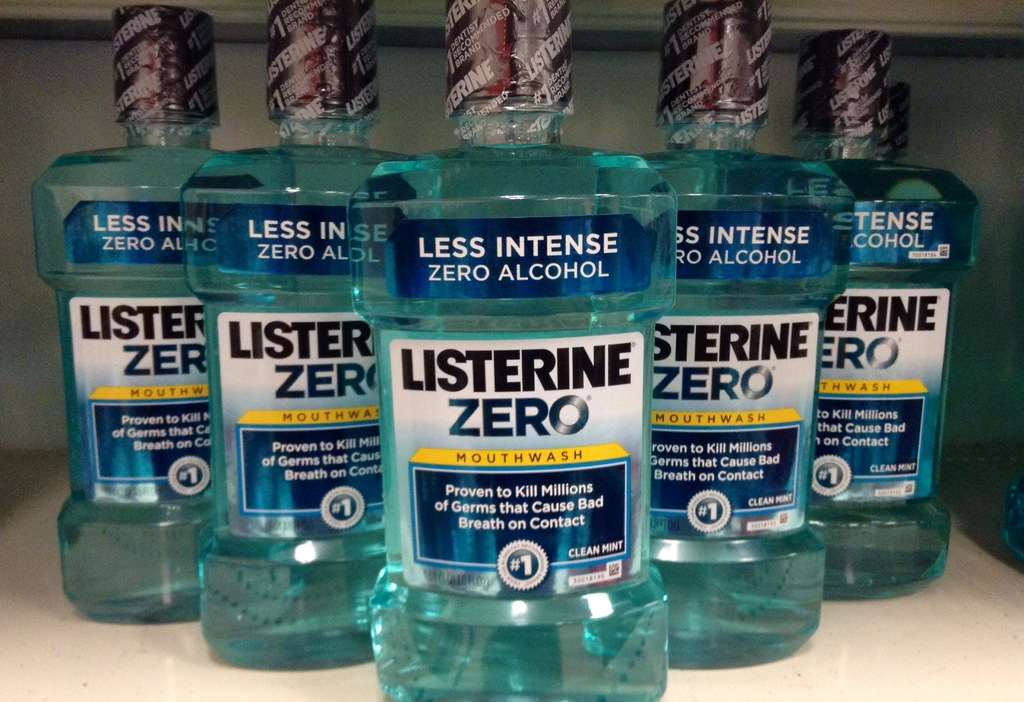

Sample 2 Prompt: The time is now 10:22 according to this clock.


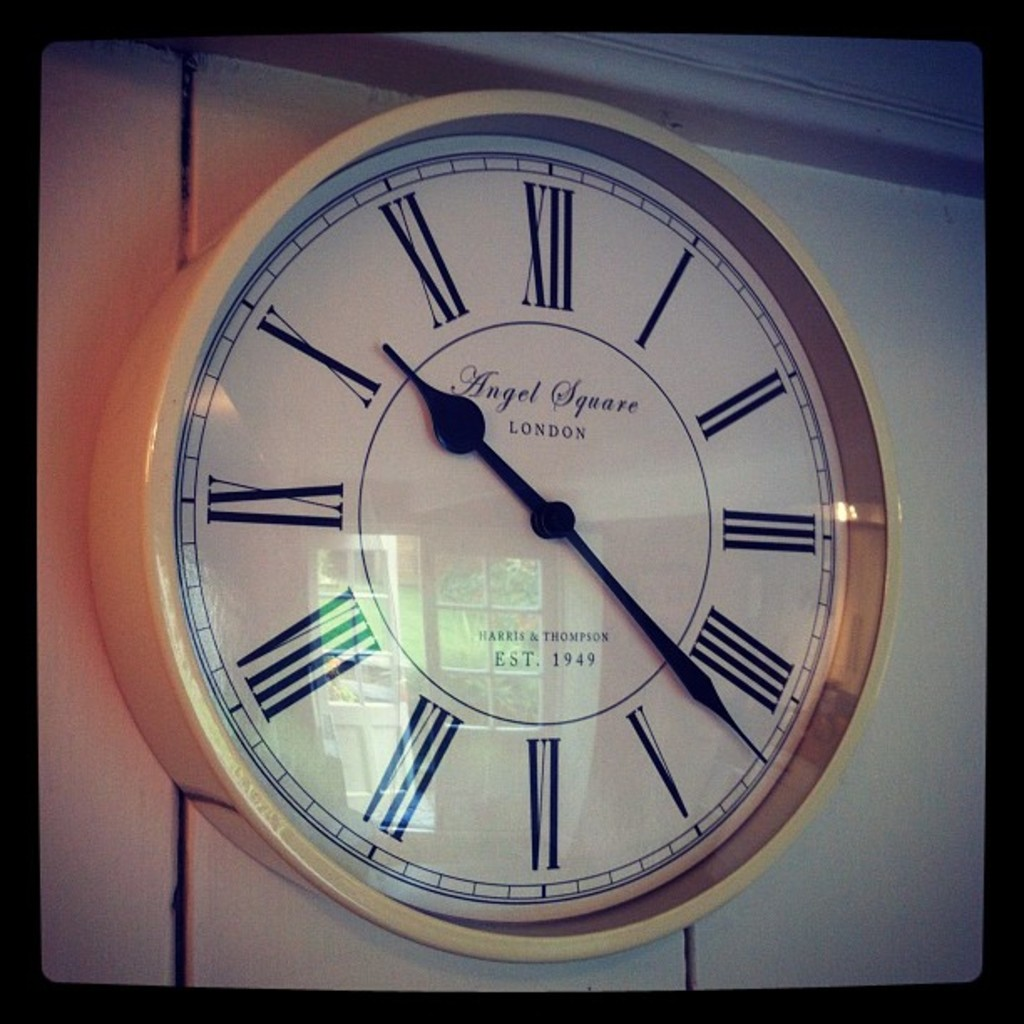

Sample 3 Prompt: Lloyd Budd's email service is powered by Google.


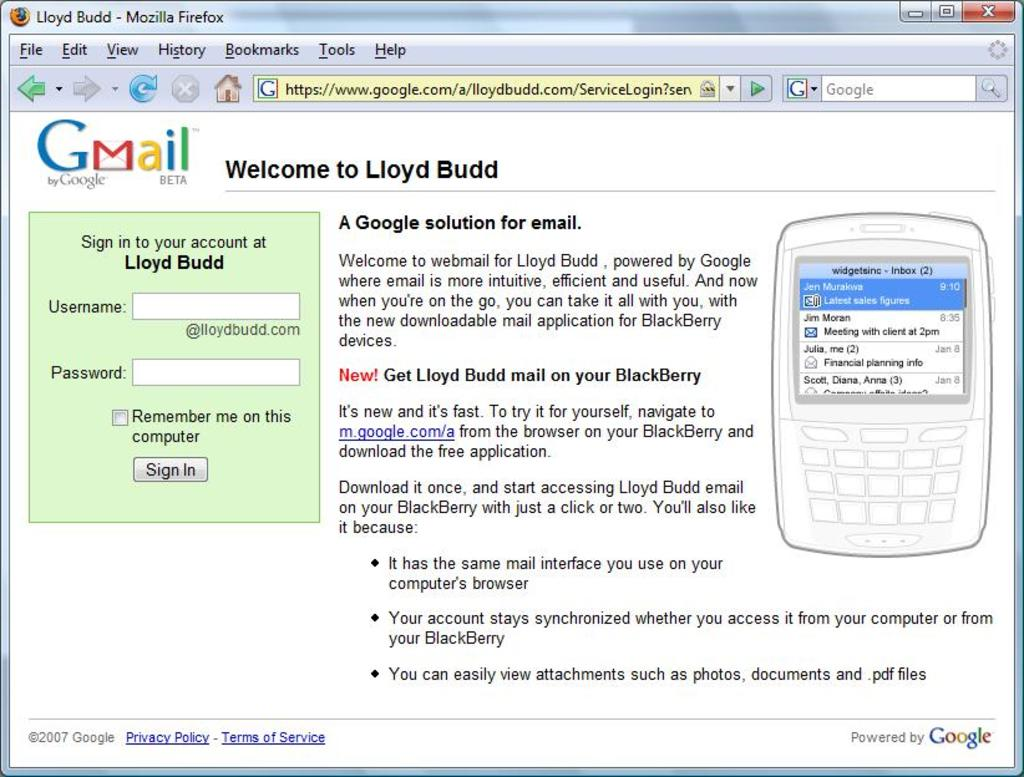

In [10]:
# 3. Display them (Conceptual Code)
for i, sample in enumerate(samples):
    image = sample['image']
    # TextCaps often has multiple captions; we usually pick the first one for training
    caption = sample['caption_str'][0] 
    
    print(f"Sample {i+1} Prompt: {caption}")
    image.show() # Uncomment to view the image locally
    display(image) # Display the image in the notebook output

# 2. Data Preprocessing

Implement necessary preprocessing steps such as 
normalization, resizing, and semantic segmentation 
to prepare data for model input.

In [11]:
# --- CONFIGURATION ---
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # Pre-trained base
OUTPUT_DIR = "./text-render-lora"
TRAIN_STEPS = 300  # Kept low for demonstration; increase to 1500+ for real results
BATCH_SIZE = 1
LEARNING_RATE = 1e-4

In [12]:

# Define Image Transforms
train_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [13]:
train_transforms(samples[0]['image']).shape

torch.Size([3, 512, 512])

In [14]:
# Load the Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")

In [ ]:
# Preprocessing Function        
from random import random


def preprocess_data(example):
    # 1. Image Processing
    image = example['image'].convert("RGB")
    pixel_values = train_transforms(image)
    
    # 2. Text Processing
    # TextCaps has multiple captions. We take the first one.
    # In your problem statement, this corresponds to the "crowd-sourced text prompt"
    caption = example['caption_str'][0]
    
    inputs = tokenizer(
        caption, 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    
    return pixel_values, inputs.input_ids[0]

# Visualize a sample
sample_data = next(iter(dataset))
print(f"Sample Caption: {sample_data['caption_str'][0]}")
sample_data['image'].show() # Uncomment to see the image

# sample_data = next(iter(dataset))
# print(f"Sample Caption: {sample_data['caption_str'][0]}")
# sample_data['image'].show() # Uncomment to see the image

# sample_data = next(iter(dataset))
# print(f"Sample Caption: {sample_data['caption_str'][0]}")
# sample_data['image'].show() # Uncomment to see the image

# Preprocess the sample
pixel_values_sample, input_ids_sample = preprocess_data(sample_data)
print(f"Pixel Values Shape: {pixel_values_sample.shape}")
print(f"Input IDs Shape: {input_ids_sample.shape}")

Sample Caption: Five Listerine Zero mouthwash bottles on a store shelf
Pixel Values Shape: torch.Size([3, 512, 512])
Input IDs Shape: torch.Size([77])


# 3. Model Development

Implement the model (e.g., Faster R-CNN) and 
integrate relevant techniques (contextual 
awareness, multi-task learning, etc.) for improved 
performance.

In [21]:
# Cell 4
from diffusers import AutoencoderKL

# Load Core Components
# VAE is crucial for compressing images into latents
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")

# Freeze original weights
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Configure LoRA
lora_config = LoraConfig(
    r=16, 
    lora_alpha=32,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    lora_dropout=0.05,
    bias="none",
)

# Add LoRA to UNet
unet = get_peft_model(unet, lora_config)

# Move to GPU and set Precision
# VAE and Text Encoder stay in FP16 for speed
device = accelerator.device
unet.to(device)
vae.to(device, dtype=torch.float16)
text_encoder.to(device, dtype=torch.float16)

print("Models loaded and VAE ready.")

Loading weights: 100%|██████████| 196/196 [00:00<00:00, 1027.36it/s, Materializing param=text_model.final_layer_norm.weight]                   
CLIPTextModel LOAD REPORT from: runwayml/stable-diffusion-v1-5
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Models loaded and VAE ready.


In [ ]:
# Cell 5
optimizer = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE)
unet.train()

print(f"--- Starting Training for {TRAIN_STEPS} steps ---")

data_iter = iter(dataset)

# Get the dtype of the unet to ensure consistency
unet_dtype = next(unet.parameters()).dtype

for step in range(TRAIN_STEPS):
    # --- 1. Get Data ---
    try:
        example = next(data_iter)
    except StopIteration:
        data_iter = iter(dataset) # Restart if we run out
        example = next(data_iter)
        
    pixel_values, input_ids = preprocess_data(example)
    
    # Move to GPU
    # pixel_values shape: [1, 3, 512, 512]
    pixel_values = pixel_values.unsqueeze(0).to(device, dtype=torch.float16) 
    input_ids = input_ids.unsqueeze(0).to(device)
    
    # --- 2. VAE ENCODING (The Fix) ---
    # We must compress the image into latents before feeding it to the UNet
    with torch.no_grad():
        # Encode image to latent distribution
        latents = vae.encode(pixel_values).latent_dist.sample()
        
        # IMPORTANT: Scale the latents. SD v1.5 uses a specific scaling factor (0.18215)
        # Without this, the latents will be the wrong magnitude for the UNet
        latents = latents * vae.config.scaling_factor
        
        # latents shape is now [1, 4, 64, 64] -> Correct for UNet

    # --- 3. Forward Pass ---
    
    # Create random noise (same shape as latents, NOT pixels)
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (1,), device=device)
    
    # Add noise to the LATENTS (Forward Diffusion)
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
    
    # Get text embeddings
    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids)[0]
    
    # Ensure dtype consistency (LoRA mixed precision handling)
    noisy_latents = noisy_latents.to(dtype=unet_dtype)
    encoder_hidden_states = encoder_hidden_states.to(dtype=unet_dtype)
    
    # Predict the noise residual using the UNet
    # Input is now 4-channel latents, which matches the UNet's expectation
    model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
    
    # --- 4. Calculate Loss & Backprop ---
    loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if step % 1 == 0:
        print(f"Step {step}: Loss: {loss.item():.4f}")

# Save the adapter
unet.save_pretrained(OUTPUT_DIR)
print("--- Training Finished & Model Saved ---")

--- Starting Training for 300 steps ---
Step 0: Loss: 0.2083


KeyboardInterrupt: 

In [ ]:
type(encoder_hidden_states)
#type(noisy_image)

# 4. Evaluation Metrics

Evaluate model performance using appropriate 
metrics (precision, recall, F1-score, speed, etc.) and 
justify their relevance to the task.

# Justification

# Preprocessing Function        


def preprocess_data(example):
    # 1. Image Processing
    image = example['image'].convert("RGB")
    pixel_values = train_transforms(image)
    
    # 2. Text Processing
    # TextCaps has multiple captions. We take the first one.
    # In your problem statement, this corresponds to the "crowd-sourced text prompt"
    caption = example['caption_str'][0]
    
    inputs = tokenizer(
        caption, 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    
    return pixel_values, inputs.input_ids[0]

# Visualize a sample
sample_data = next(iter(dataset))
print(f"Sample Caption: {sample_data['caption_str'][0]}")
sample_data['image'].show() # Uncomment to see the image
